In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from keras.src.metrics import Recall, Precision, F1Score
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import tensorflow as tf

import mlflow
import numpy as np
from dotenv import load_dotenv

from src.functions import create_model, plot_data, check_gpus, load_stations_from_path, \
    create_test_datasets, plot_keras_history, preprocces
from src.utils import now_formatted, setup_logger, format_with_border, measure_execution_time

2023-12-12 18:18:55.294270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 18:18:55.294321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 18:18:55.294363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 18:18:55.303449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
check_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2023-12-12 18:18:57.753709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 18:18:57.769693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 18:18:57.770193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
load_dotenv()
mlflow_port = os.getenv('MLFLOW_PORT')
mlflow_uri = f'http://localhost:{mlflow_port}'
mlflow_experiment_name = f'Benchmark'
train_path = '../data/labeled_benchmark/train'
test_path = '../data/labeled_benchmark/test'
log_file_path = '/tmp/benchmark.log'

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(mlflow_experiment_name)
mlflow.tensorflow.autolog()

In [4]:
SEQUENCE_LENGTH = 90
TARGET_START_INDEX = SEQUENCE_LENGTH - 1
FEATURE_COLUMNS = [
    'HS',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'TSS_30MIN_MEAN',
    'RSWR_30MIN_MEAN',
    'TA_30MIN_MEAN',
    'VW_30MIN_MEAN'
]
TARGET_COLUMN = 'no_snow'
DATE_COLUMN = 'measure_date'
SPLIT_PERCENTAGE = 0.8
DATASET_BATCH_SIZE = 64

# Model configuration
MODEL_ARCHITECTURE = "128(l)-64-8(d)-1"
MODEL_INPUT_SHAPE = (SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
MODEL_DROPOUT_RATE = 0.5
MODEL_OPTIMIZER = 'adam'
MODEL_METRICS = ['accuracy', Recall(), Precision()],

MODEL_LOSS = 'binary_crossentropy'
MODEL_BATCH_SIZE = 64
MODEL_EPOCHS = 15

EXPERIMENT_NAME = 'replicate_with_seasonal_seq_v2'

def log_parameters(logging, mlflow):
    global_vars = globals()
    for var_name, value in global_vars.items():
        if var_name.isupper():
            logging.info(f'{var_name}: {value}')
            mlflow.log_param(f'benchmark_{var_name.lower()}', value)

In [5]:
def generate_confusion_matrix():
    y_true = [ts.loc[TARGET_START_INDEX:, 'no_snow'].values for ts in testing_stations.values()]
    y_pred = [model.predict(td, verbose=0).reshape((-1,)) > 0.5 for td in test_datasets]
    n_matrices = len(y_true)
    n_cols = 3
    n_rows = (n_matrices + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    fig.tight_layout(pad=5.0)

    for i in range(n_matrices):
        ax = axes[i // n_cols, i % n_cols]
        cm = confusion_matrix(y_true[i], y_pred[i])
        sns.heatmap(cm, annot=True, fmt='d', cmap="crest", ax=ax)
        ax.set_title(list(testing_stations.keys())[i])
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    for j in range(i + 1, n_rows * n_cols):
        axes[j // n_cols, j % n_cols].axis('off')

    plt.show()
    
    return fig

In [6]:
training_stations = load_stations_from_path(train_path)
testing_stations = {station.iloc[0]['station_code']: station for station in load_stations_from_path(test_path)}

In [7]:
def create_train_val_datasets(
        dfs,
        split_percentage,
        feature_columns,
        target_column,
        sequence_length,
        target_start_index,
        batch_size
):
    total_sequences = sum(len(df) - sequence_length for df in dfs)

    seq_array = np.zeros((total_sequences, sequence_length, len(feature_columns)))
    target_array = np.zeros(total_sequences)

    insert_idx = 0

    for df in dfs:
        df = preprocces(df) 
        features = df[feature_columns].values
        targets = df[target_column].values if target_column else np.zeros(len(df))

        max_index = len(df) - sequence_length

        for i in range(max_index):
            seq_array[insert_idx] = features[i:i + sequence_length]
            target_array[insert_idx] = targets[i + sequence_length - 1]
            insert_idx += 1

    indices = np.arange(seq_array.shape[0])
    np.random.shuffle(indices)
    shuffled_seq_array = seq_array[indices]
    shuffled_target_array = target_array[indices]

    split_index = int(split_percentage * len(shuffled_seq_array))

    train_seq = shuffled_seq_array[:split_index]
    val_seq = shuffled_seq_array[split_index:]
    train_target = shuffled_target_array[:split_index]
    val_target = shuffled_target_array[split_index:]

    mean = train_seq.mean(axis=(0, 1))
    std = train_seq.std(axis=(0, 1))

    train_seq = (train_seq - mean) / std
    val_seq = (val_seq - mean) / std

    train_dataset = tf.data.Dataset.from_tensor_slices((train_seq, train_target)).cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_seq, val_target)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, mean, std, len(train_seq), len(val_seq), None

2023-12-12 18:18:58 INFO 3965145381 - <module>: ======================================= Starting experiment =======================================
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: SEQUENCE_LENGTH: 90
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: TARGET_START_INDEX: 89
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: FEATURE_COLUMNS: ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'TSS_30MIN_MEAN', 'RSWR_30MIN_MEAN', 'TA_30MIN_MEAN', 'VW_30MIN_MEAN']
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: TARGET_COLUMN: no_snow
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: DATE_COLUMN: measure_date
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: SPLIT_PERCENTAGE: 0.8
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: DATASET_BATCH_SIZE: 64
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: MODEL_ARCHITECTURE: 128(l)-64-8(d)-1
2023-12-12 18:18:58 INFO 2031996372 - log_parameters: MODEL_INPUT_SHAPE: (90, 9)
2023-12-12 18:18:58 IN

2023-12-12 18:19:02.809444: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2023-12-12 18:19:03 INFO 3965145381 - <module>: ========================================== Fitting Model ==========================================
Epoch 1/15


2023-12-12 18:19:08.196894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-12 18:19:09.489597: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0ec9aee500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 18:19:09.489626: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti with Max-Q Design, Compute Capability 6.1
2023-12-12 18:19:09.499216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-12 18:19:09.603602: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   5/1409 [..............................] - ETA: 22s - loss: 0.5628 - accuracy: 0.8250 - recall: 0.7431 - precision: 0.7431    WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0136s). Check your callbacks.
2023-12-12 18:19:10 WARNING callbacks - _call_batch_end_hook: Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0136s). Check your callbacks.
1409/1409 [==============================] - 32s 20ms/step - loss: 0.1193 - accuracy: 0.9551 - recall: 0.9441 - precision: 0.9308 - val_loss: 0.0911 - val_accuracy: 0.9643 - val_recall: 0.9524 - val_precision: 0.9469
Epoch 2/15
1409/1409 [==============================] - 28s 20ms/step - loss: 0.0863 - accuracy: 0.9679 - recall: 0.9570 - precision: 0.9530 - val_loss: 0.0739 - val_accuracy: 0.9713 - val_recall: 0.9612 - val_precision: 0.9578
Epoch 3/15
1409/1409 [==============

2023/12/12 18:26:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/code/other/snow-height-anomaly-detection/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


2023-12-12 18:26:46 INFO 3965145381 - <module>: Model fitting completed in 7m43s
2023-12-12 18:26:46 INFO 3965145381 - <module>: ================================== Evaluating Model on Test Data ==================================
2023-12-12 18:26:48 INFO 3965145381 - <module>: Station: KLO2, Samples: 9600, Loss: 0.030, Accuracy: 0.989, Precision: 0.993, Recall: 0.979, F1 Score: 0.986
2023-12-12 18:26:49 INFO 3965145381 - <module>: Station: SHE2, Samples: 7785, Loss: 0.105, Accuracy: 0.960, Precision: 0.991, Recall: 0.927, F1 Score: 0.958
2023-12-12 18:26:50 INFO 3965145381 - <module>: Station: SLF2, Samples: 9218, Loss: 0.345, Accuracy: 0.935, Precision: 0.967, Recall: 0.918, F1 Score: 0.942
2023-12-12 18:26:52 INFO 3965145381 - <module>: Station: STN2, Samples: 8889, Loss: 0.235, Accuracy: 0.941, Precision: 0.834, Recall: 0.984, F1 Score: 0.903
2023-12-12 18:26:53 INFO 3965145381 - <module>: Station: TRU2, Samples: 9597, Loss: 0.051, Accuracy: 0.981, Precision: 0.968, Recall: 0.971, F1

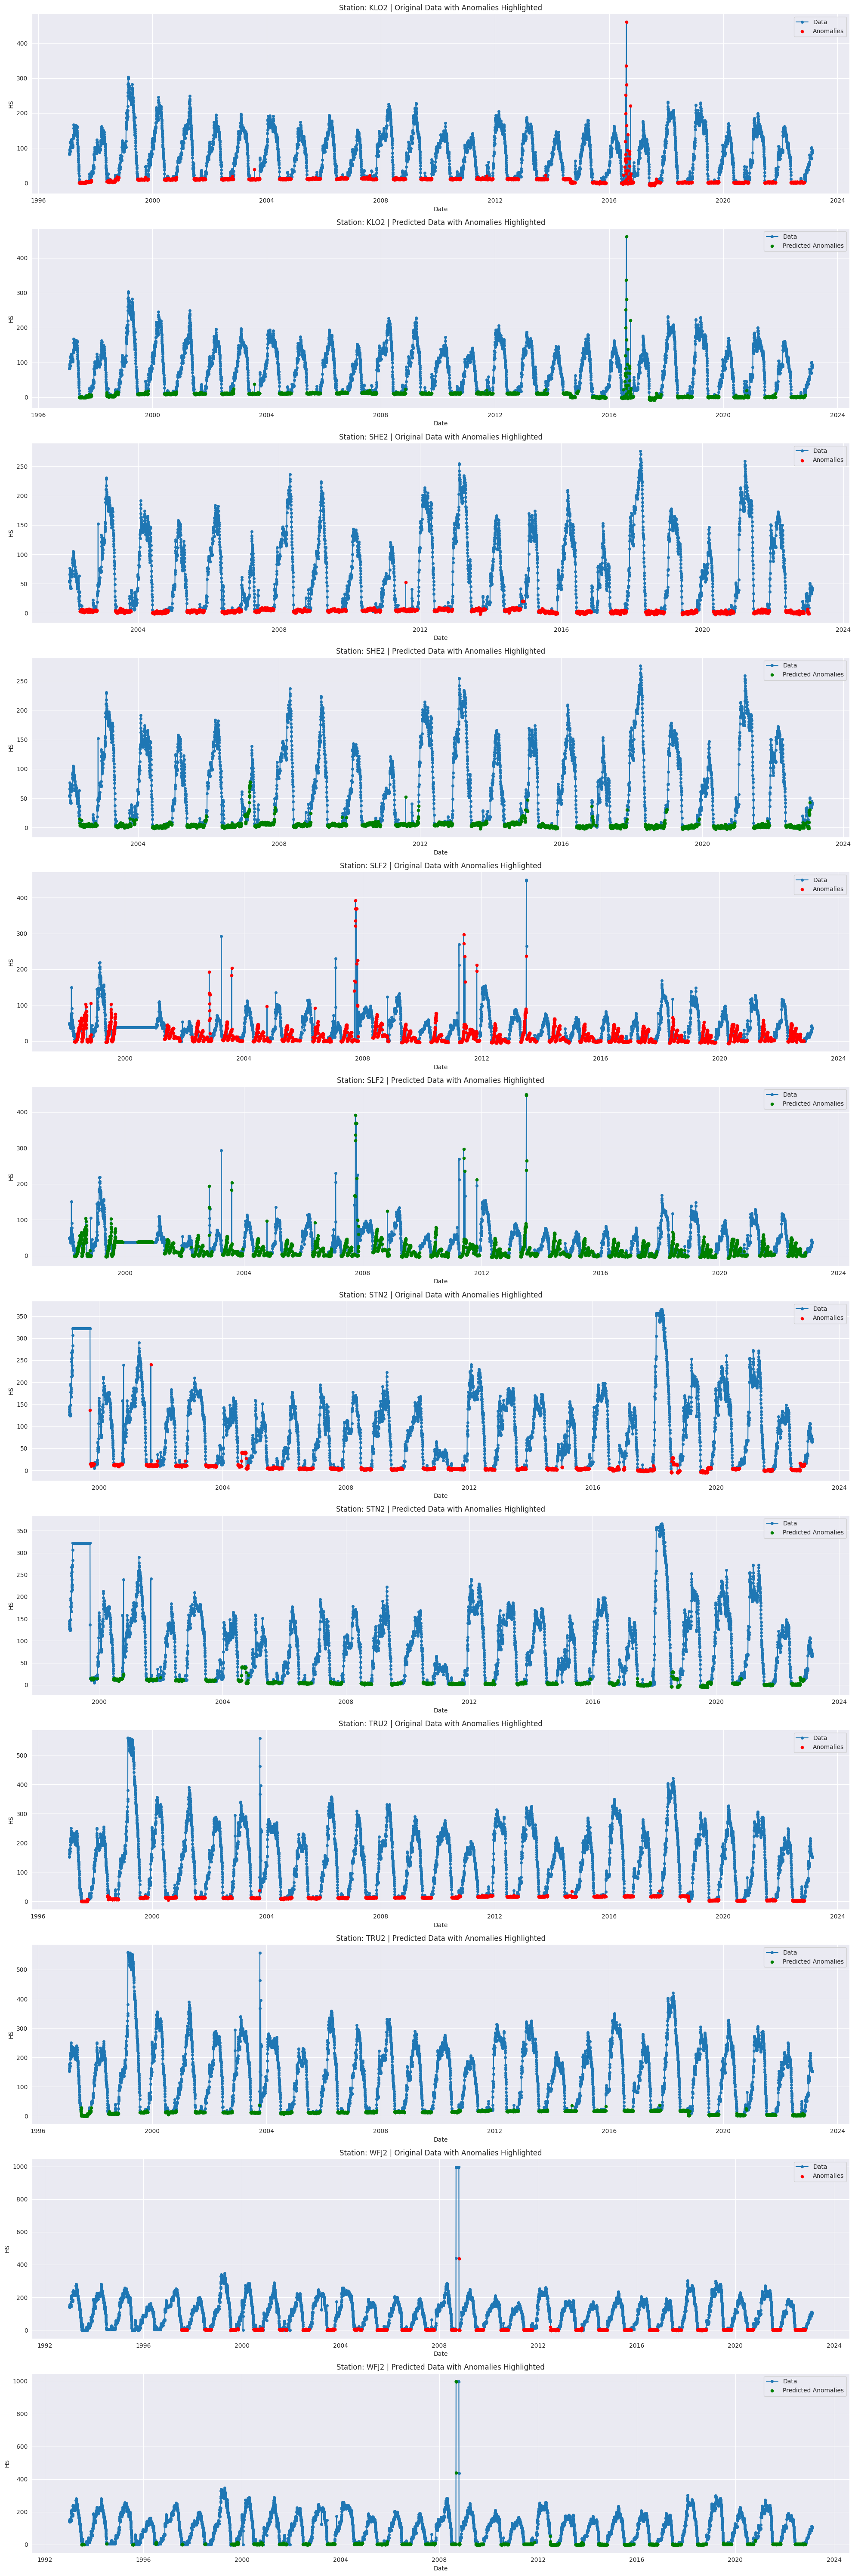

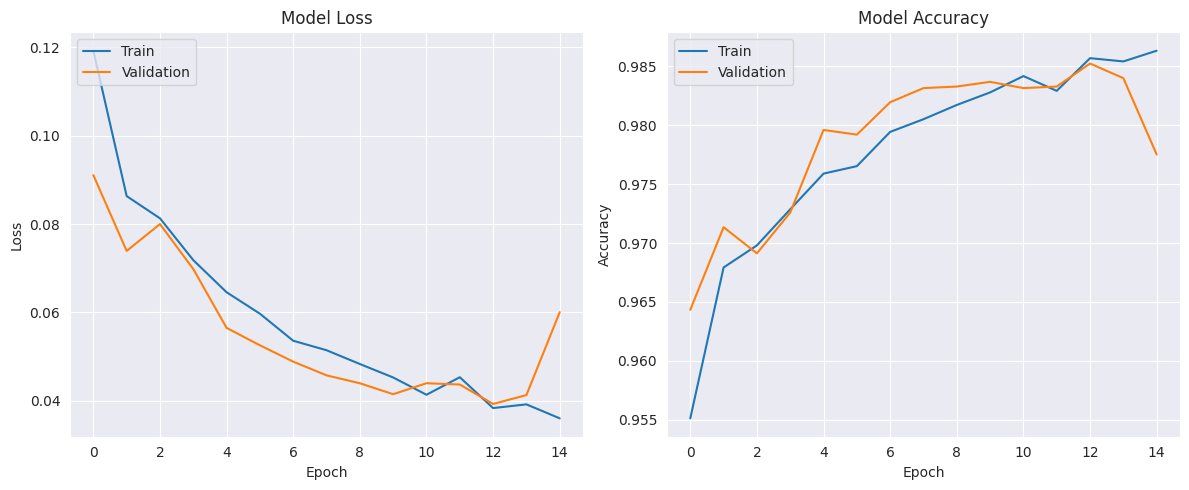

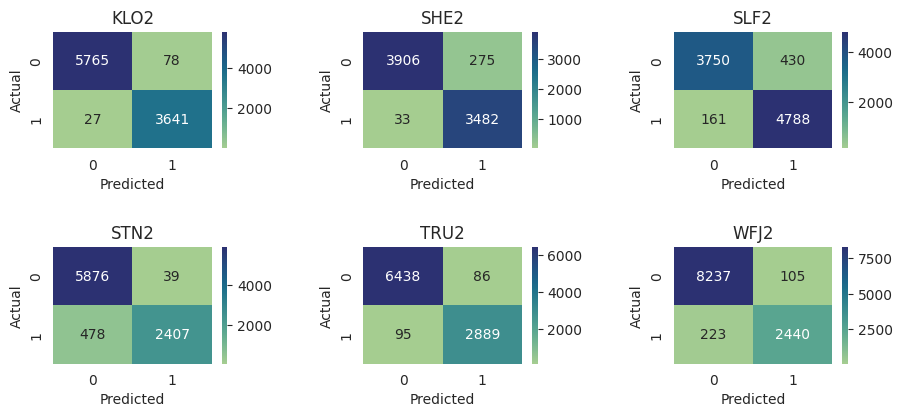

In [8]:
with mlflow.start_run(run_name=f"{now_formatted()}_{EXPERIMENT_NAME}"):
    logging, tmp_log_file = setup_logger(log_file_path=log_file_path)
    logging.info(format_with_border('Starting experiment'))
    
    log_parameters(logging, mlflow)
    logging.info(format_with_border('Preparing Training Data'))
    train_dataset, val_dataset, mean, std, num_train_samples, num_val_samples, _ = create_train_val_datasets(
        training_stations, SPLIT_PERCENTAGE, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE
    )

    logging.info(f"Training samples: {num_train_samples}")
    logging.info(f"Validation samples: {num_val_samples}")
    mlflow.log_param('benchmark_training_samples', num_train_samples)
    mlflow.log_param('benchmark_validation_samples', num_val_samples)

    model = create_model(MODEL_ARCHITECTURE, MODEL_INPUT_SHAPE, logging=None, dropout_rate=MODEL_DROPOUT_RATE, summary=False, dropout_layer='dropout')
    model.compile(
        optimizer=MODEL_OPTIMIZER,
        metrics=MODEL_METRICS,
        loss=MODEL_LOSS
    )
    
    logging.info(format_with_border('Fitting Model'))
    @measure_execution_time
    def fit_model():
        return model.fit(
            train_dataset,
            epochs=MODEL_EPOCHS,
            batch_size=MODEL_BATCH_SIZE,
            validation_data=val_dataset
        )
    history, elapsed_fitting_time = fit_model()
    logging.info(f'Model fitting completed in {elapsed_fitting_time}')
    mlflow.log_param('benchmark_model_fitting_time', elapsed_fitting_time)

    logging.info(format_with_border('Evaluating Model on Test Data'))
    test_datasets = create_test_datasets(
        testing_stations.values(), FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
    )

    all_evaluation_results = np.empty((0, 5), float)

    for j, dataset in enumerate(test_datasets):
        evaluation_results = model.evaluate(dataset, verbose=0)
        precision = evaluation_results[2]
        recall = evaluation_results[3]
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        station_name = list(testing_stations.keys())[j]
        test_df = list(testing_stations.values())[j]
        logging.info(
            f'Station: {station_name}, Samples: {len(test_df)}, Loss: {evaluation_results[0]:.3f}, Accuracy: {evaluation_results[1]:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}'
        )
        all_evaluation_results = np.append(all_evaluation_results, [evaluation_results + [f1_score]], axis=0)

    mlflow.log_metric('test_avg_loss', np.mean(all_evaluation_results[:, 0]))
    mlflow.log_metric('test_avg_accuracy', np.mean(all_evaluation_results[:, 1]))
    mlflow.log_metric('test_avg_precision', np.mean(all_evaluation_results[:, 2]))
    mlflow.log_metric('test_avg_recall', np.mean(all_evaluation_results[:, 3]))
    mlflow.log_metric('test_avg_f1_score', np.mean(all_evaluation_results[:, 4]))

    predictions = [model.predict(td, verbose=0).reshape((-1,)) > 0.5 for td in test_datasets]
    fig = plot_data(
        [test_station[TARGET_START_INDEX:] for test_station in testing_stations.values()],
        predictions=predictions,
        show=False
    )
    mlflow.log_figure(fig, 'prediction_results.png')
    mlflow.log_artifact(tmp_log_file)
    mlflow.log_figure(plot_keras_history(history), 'keras_history.png')
    mlflow.log_figure(generate_confusion_matrix(), 'confusion_matrix.png')